In [1]:
# List all device
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
# Check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Lambda, GRU, BatchNormalization, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.activations import softmax
from keras.optimizers import SGD, RMSprop
import math
import pickle
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [5]:
with open("../data/dowjones_calculated/periods750_250_240.txt", "rb") as fp:   # Unpickling
    dataset = pickle.load(fp)

In [6]:
def normalize_data(df):
    """normalize a dataframe."""
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    df = df.sub(mean, axis=0)
    df = df.div(std, axis=0)
    df = df.values
    return df
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [7]:
i = 7
timestep = 240

In [8]:
# x_train = dataset[0][i][0]['AMZN'].values * 1000
# y_train = dataset[0][i][1]['AMZN'].values * 1.0
# x_test = dataset[1][i][0]['AMZN'].values * 1000
# y_test = dataset[1][i][1]['AMZN'].values * 1.0

# x_train = dataset[0][i][0].values
# x_train = (x_train - x_train.mean())/x_train.std()
# y_train = dataset[0][i][1].values * 1.0
# x_test = dataset[1][i][0].values
# x_test = (x_test - x_test.mean())/x_test.std()
# y_test = dataset[1][i][1].values * 1.0

# x_train = dataset[0][i][0].values * 1000
# x_test = dataset[1][i][0].values * 1000

x_train = dataset[0][i][0].values
x_test = dataset[1][i][0].values

scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# x_train = normalize_data(dataset[0][i][0])
# x_test = normalize_data(dataset[1][i][0])

# y_train = get_one_hot(dataset[0][i][1].values, 2) * 1.0
# y_test = get_one_hot(dataset[1][i][1].values, 2) * 1.0
y_train = to_categorical(dataset[0][i][1].values, 2)
y_test = to_categorical(dataset[1][i][1].values, 2)

In [9]:
print(f"x train shape: {x_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"x test shape: {x_test.shape}")
print(f"y test shape: {y_test.shape}")

x train shape: (750, 31)
y train shape: (750, 31, 2)
x test shape: (490, 31)
y test shape: (490, 31, 2)


In [10]:
# The second range will be looped first
# x_series = [x_train[i:i+240] for i in range(750 - 240)]
# y_series = [y_train[i+240] for i in range(750 - 240)]
x_series = [x_train[i:i+timestep, j] for i in range(x_train.shape[0] - timestep) for j in range(x_train.shape[1])]
y_series = [y_train[i+timestep, j] for i in range(y_train.shape[0] - timestep) for j in range(y_train.shape[1])]
x = np.array(x_series)
y = np.array(y_series)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (15810, 240)
y shape: (15810, 2)


In [11]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))
print(f"x shape: {x.shape}")


x shape: (15810, 240, 1)


In [12]:
dropout_rate = 0.1
# expected input data shape: (batch_size, timesteps, data_dim)
regressor = Sequential()

# regressor.add(Bidirectional(LSTM(units=25, input_shape=(timestep, 1), dropout=dropout_rate)))
# regressor.add(LSTM(units=25, input_shape=(timestep, 1), dropout=dropout_rate))

regressor.add(LSTM(units=25, return_sequences = True, batch_input_shape=(527, timestep, 1), dropout=dropout_rate, stateful=False))
# regressor.add(LSTM(units=25, return_sequences = True,dropout=dropout_rate, stateful=False))
# regressor.add(LSTM(units=25, return_sequences = True,dropout=dropout_rate, stateful=False))
regressor.add(LSTM(units=25, dropout=dropout_rate, stateful=False))
# regressor.add(LSTM(units=25, input_shape=(timestep, 1), dropout=dropout_rate))
# regressor.add(GRU(units=25, input_shape=(timestep, 1), dropout=dropout_rate))
# regressor.add(Dense(100, input_shape=(timestep, ), activation='relu'))
regressor.add(Dense(100, activation='relu'))
regressor.add(Dense(2, activation='softmax'))
regressor.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (527, 240, 25)            2700      
_________________________________________________________________
lstm_2 (LSTM)                (527, 25)                 5100      
_________________________________________________________________
dense_1 (Dense)              (527, 100)                2600      
_________________________________________________________________
dense_2 (Dense)              (527, 2)                  202       
Total params: 10,602
Trainable params: 10,602
Non-trainable params: 0
_________________________________________________________________


In [13]:
result = regressor.fit(x, y, epochs=1000,batch_size=527, validation_split=0.2, shuffle=False, callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=200),
             ModelCheckpoint(filepath='../model/LSTM/best_model.h5', monitor='val_acc', save_best_only=True)])

# regressor.fit(x, y, epochs=1000,batch_size=500, validation_split=0.2, callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=20),
#              ModelCheckpoint(filepath='../model/LSTM/best_model.h5', monitor='val_acc', save_best_only=True)])


Train on 12648 samples, validate on 3162 samples
Epoch 1/1000
12648/12648 [==============================] - 8s 647us/step - loss: 0.6926 - acc: 0.5153 - val_loss: 0.6926 - val_acc: 0.5262
Epoch 2/1000
12648/12648 [==============================] - 7s 581us/step - loss: 0.6925 - acc: 0.5168 - val_loss: 0.6924 - val_acc: 0.5266
Epoch 3/1000
12648/12648 [==============================] - 7s 563us/step - loss: 0.6925 - acc: 0.5146 - val_loss: 0.6925 - val_acc: 0.5240
Epoch 4/1000
12648/12648 [==============================] - 7s 553us/step - loss: 0.6925 - acc: 0.5155 - val_loss: 0.6925 - val_acc: 0.5225
Epoch 5/1000
12648/12648 [==============================] - 7s 583us/step - loss: 0.6925 - acc: 0.5156 - val_loss: 0.6927 - val_acc: 0.5240
Epoch 6/1000
12648/12648 [==============================] - 8s 594us/step - loss: 0.6923 - acc: 0.5162 - val_loss: 0.6928 - val_acc: 0.5244
Epoch 7/1000
12648/12648 [==============================] - 8s 646us/step - loss: 0.6925 - acc: 0.5145 - val_lo

Epoch 59/1000
12648/12648 [==============================] - 8s 613us/step - loss: 0.6916 - acc: 0.5204 - val_loss: 0.6926 - val_acc: 0.5218
Epoch 60/1000
12648/12648 [==============================] - 8s 619us/step - loss: 0.6915 - acc: 0.5201 - val_loss: 0.6928 - val_acc: 0.5237
Epoch 61/1000
12648/12648 [==============================] - 8s 616us/step - loss: 0.6916 - acc: 0.5200 - val_loss: 0.6932 - val_acc: 0.5244
Epoch 62/1000
12648/12648 [==============================] - 8s 619us/step - loss: 0.6916 - acc: 0.5225 - val_loss: 0.6931 - val_acc: 0.5218
Epoch 63/1000
12648/12648 [==============================] - 8s 614us/step - loss: 0.6912 - acc: 0.5237 - val_loss: 0.6938 - val_acc: 0.5187
Epoch 64/1000
12648/12648 [==============================] - 8s 613us/step - loss: 0.6915 - acc: 0.5193 - val_loss: 0.6934 - val_acc: 0.5171
Epoch 65/1000
12648/12648 [==============================] - 8s 611us/step - loss: 0.6913 - acc: 0.5219 - val_loss: 0.6940 - val_acc: 0.5155
Epoch 66/1000

Epoch 117/1000
12648/12648 [==============================] - 8s 601us/step - loss: 0.6888 - acc: 0.5270 - val_loss: 0.7255 - val_acc: 0.5082
Epoch 118/1000
12648/12648 [==============================] - 8s 603us/step - loss: 0.6886 - acc: 0.5283 - val_loss: 0.7232 - val_acc: 0.5073
Epoch 119/1000
12648/12648 [==============================] - 8s 622us/step - loss: 0.6892 - acc: 0.5289 - val_loss: 0.7187 - val_acc: 0.5114
Epoch 120/1000
12648/12648 [==============================] - 8s 619us/step - loss: 0.6885 - acc: 0.5297 - val_loss: 0.7224 - val_acc: 0.5114
Epoch 121/1000
12648/12648 [==============================] - 8s 619us/step - loss: 0.6881 - acc: 0.5331 - val_loss: 0.7218 - val_acc: 0.5089
Epoch 122/1000
12648/12648 [==============================] - 8s 620us/step - loss: 0.6884 - acc: 0.5301 - val_loss: 0.7184 - val_acc: 0.5079
Epoch 123/1000
12648/12648 [==============================] - 8s 617us/step - loss: 0.6880 - acc: 0.5361 - val_loss: 0.7232 - val_acc: 0.5117
Epoch 

Epoch 175/1000
12648/12648 [==============================] - 7s 578us/step - loss: 0.6799 - acc: 0.5598 - val_loss: 0.7560 - val_acc: 0.5139
Epoch 176/1000
12648/12648 [==============================] - 7s 574us/step - loss: 0.6806 - acc: 0.5520 - val_loss: 0.7487 - val_acc: 0.5209
Epoch 177/1000
12648/12648 [==============================] - 8s 626us/step - loss: 0.6801 - acc: 0.5531 - val_loss: 0.7453 - val_acc: 0.5098
Epoch 178/1000
12648/12648 [==============================] - 8s 632us/step - loss: 0.6803 - acc: 0.5552 - val_loss: 0.7495 - val_acc: 0.5142
Epoch 179/1000
12648/12648 [==============================] - 8s 595us/step - loss: 0.6802 - acc: 0.5537 - val_loss: 0.7428 - val_acc: 0.5079
Epoch 180/1000
12648/12648 [==============================] - 7s 578us/step - loss: 0.6811 - acc: 0.5512 - val_loss: 0.7436 - val_acc: 0.5142
Epoch 181/1000
12648/12648 [==============================] - 7s 575us/step - loss: 0.6788 - acc: 0.5593 - val_loss: 0.7447 - val_acc: 0.5145
Epoch 

Epoch 233/1000
12648/12648 [==============================] - 7s 575us/step - loss: 0.6698 - acc: 0.5741 - val_loss: 0.7788 - val_acc: 0.5025
Epoch 234/1000
12648/12648 [==============================] - 7s 577us/step - loss: 0.6708 - acc: 0.5730 - val_loss: 0.7819 - val_acc: 0.5047
Epoch 235/1000
12648/12648 [==============================] - 7s 571us/step - loss: 0.6694 - acc: 0.5733 - val_loss: 0.7838 - val_acc: 0.5066
Epoch 236/1000
12648/12648 [==============================] - 8s 609us/step - loss: 0.6698 - acc: 0.5784 - val_loss: 0.7792 - val_acc: 0.5076
Epoch 237/1000
12648/12648 [==============================] - 8s 605us/step - loss: 0.6695 - acc: 0.5790 - val_loss: 0.7866 - val_acc: 0.5066
Epoch 238/1000
12648/12648 [==============================] - 8s 621us/step - loss: 0.6687 - acc: 0.5733 - val_loss: 0.7847 - val_acc: 0.5047
Epoch 239/1000
12648/12648 [==============================] - 8s 604us/step - loss: 0.6698 - acc: 0.5727 - val_loss: 0.7852 - val_acc: 0.5051
Epoch 

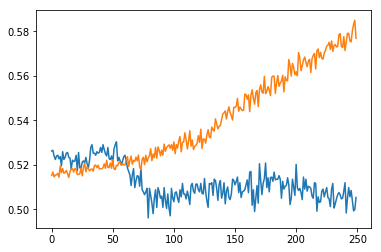

In [14]:
plt.plot(result.history["val_acc"])
plt.plot(result.history["acc"])

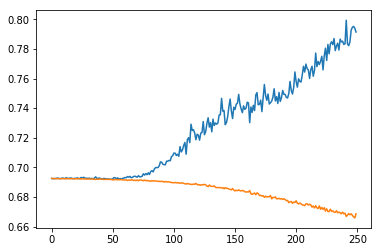

In [15]:
plt.plot(result.history["val_loss"])
plt.plot(result.history["loss"])